# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [1]:
# Import packages
import os
import re
from collections import ChainMap
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import colors
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from pandas.io.json import json_normalize
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em
import radiance as rd

### Set Package Options

In [2]:
# Set options
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
register_matplotlib_converters()

### Set Working Directory

In [3]:
# Set working directory (move up one folder)
os.chdir("..")

## Data Preparation

### Define File Paths

In [4]:
# Set path to radiance files
psu_lat_lon_path = os.path.join(
    "02-raw-data", "nasa-black-marble", 
    "penn-state-campus-sep-2018-may-2020-pixel-lat-lon.csv")

psu_radiance_path = os.path.join(
    "02-raw-data", "nasa-black-marble", 
    "penn-state-campus-sep-2018-may-2020-radiance.csv")

psu_cloud_mask_path = os.path.join(
    "02-raw-data", "nasa-black-marble", 
    "penn-state-campus-sep-2018-may-2020-cloud-mask.csv")

In [5]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: 02-raw-data\nasa-black-marble\penn-state-campus-sep-2018-may-2020-pixel-lat-lon.csv
Path exists: 02-raw-data\nasa-black-marble\penn-state-campus-sep-2018-may-2020-radiance.csv
Path exists: 02-raw-data\nasa-black-marble\penn-state-campus-sep-2018-may-2020-cloud-mask.csv


### Read CSV Files to Geodataframes

In [6]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [7]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [8]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [9]:
psu_radiance_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

In [10]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [11]:
psu_cloud_mask_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

### Add Missings Dates and Data

In [12]:
# Fill radiance data with missing dates (dates specified by user)
psu_radiance_filled = rd.add_missing_data(
    psu_radiance_df, '2018-09-01', '2020-05-07')

In [13]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

In [14]:
# Fill cloud mask data with missing dates
psu_cloud_mask_filled = rd.add_missing_data(
    psu_cloud_mask_df, '2018-09-01', '2020-05-07')

In [15]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

### Extract Plotting Extent & Transform

In [16]:
# Extract PSU extent and transform from lat/lon dataframe
psu_extent, psu_transform, psu_shape = rd.extract_extent(
    study_area=psu_lat_lon_df, 
    longitude_column='Longitude', 
    latitude_column='Latitude')

In [17]:
# Display extent (left, right, bottom, top)
psu_extent

(-77.93735504, -77.77068837333334, 40.754917322941175, 40.82991733)

In [18]:
# Display tranform (used for export)
psu_transform

Affine(0.004166666666666521, 0.0, -77.93735504,
       0.0, -0.004166667058823534, 40.82991733)

In [19]:
# Display shape
psu_shape

(18, 40)

### Create GeoDataFrame of Lat/Lon Points

In [20]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [21]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

**Penn State Academic Calendars**

[All Academic Calendars](http://www.registrar.psu.edu/academic-calendars/)

[2018-2019 Academic Calendar](http://www.registrar.psu.edu/academic-calendars/2018-19.cfm)

[2019-2020 Academic Calendar](http://www.registrar.psu.edu/academic-calendars/2019-20.cfm)

### Store Daily Radiance Values

In [22]:
# Get list of dates (daily) from Sept 1, 2018 to May 7, 2020
date_list = rd.create_date_list(start_date='2018-09-01', end_date='2020-05-07')

In [23]:
# Display number of days in list
len(date_list)

615

In [24]:
# Store all daily filled values in nested dictionary
#  (indexed by [Year][Month][Day])
radiance_sept_2018_may_2020 = rd.store_data(
    psu_radiance_filled, psu_cloud_mask_filled, 
    mask_value=100, array_shape=psu_shape, dates=date_list)

In [25]:
# Initialize counters for years/months/days in dictionary
years = months = days = 0
radiance_dict = radiance_sept_2018_may_2020

# Loop through all years
for key_year in radiance_dict.keys():

    # Add to counter for each year
    years += 1
    
    # Loop through all months
    for key_month in radiance_dict.get(key_year).keys():
        
        # Add to counter for each month
        months += 1
        
        # Loop through all days
        for key_day in radiance_dict.get(key_year).get(key_month):
        
            # Add to counter for each day
            days += 1

In [26]:
# Display number of years/months/days in dictionary
print(f"Entries in Radiance Dictionary\nYears:    {years}\nMonths:  {months}\nDays:   {days}")

Entries in Radiance Dictionary
Years:    3
Months:  21
Days:   615


## Calculate Radiance Statistics (Per-Pixel Basis)

In [27]:
# Define date range from Fall 2018 to Spring 2020
psu_dates = [
    ('2018-09-01', '2020-05-07')
]

### Mean

In [28]:
# Store continuous ranges means in dictionary
psu_radiance_mean_dict = rd.store_continuous_range_statistic(
    radiance_daily=radiance_sept_2018_may_2020,
    date_range_list=psu_dates, statistic='mean')

In [29]:
# Show keys (should be single key)
psu_radiance_mean_dict.keys()

dict_keys(['20180901-20200507'])

In [30]:
# Get shape array
psu_radiance_mean_dict.get('20180901-20200507').shape

(18, 40)

In [31]:
# Get radiance array
psu_radiance_mean_arr = psu_radiance_mean_dict.get('20180901-20200507')

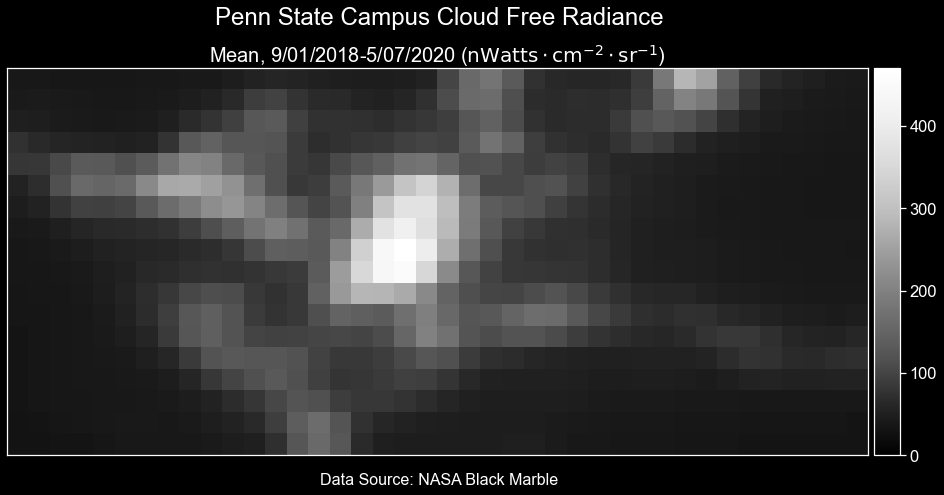

In [32]:
# Plot mean values
rd.plot_values(psu_radiance_mean_arr, title="Mean, 9/01/2018-5/07/2020")

plt.show()

### Variance

In [33]:
# Store continuous ranges variance in dictionary
psu_radiance_variance_dict = rd.store_continuous_range_statistic(
    radiance_daily=radiance_sept_2018_may_2020,
    date_range_list=psu_dates, statistic='variance')

In [34]:
# Show keys (should be single key)
psu_radiance_variance_dict.keys()

dict_keys(['20180901-20200507'])

In [35]:
# Get radiance array
psu_radiance_variance_arr = psu_radiance_variance_dict.get('20180901-20200507')

In [36]:
# Get shape
psu_radiance_variance_arr.shape

(18, 40)

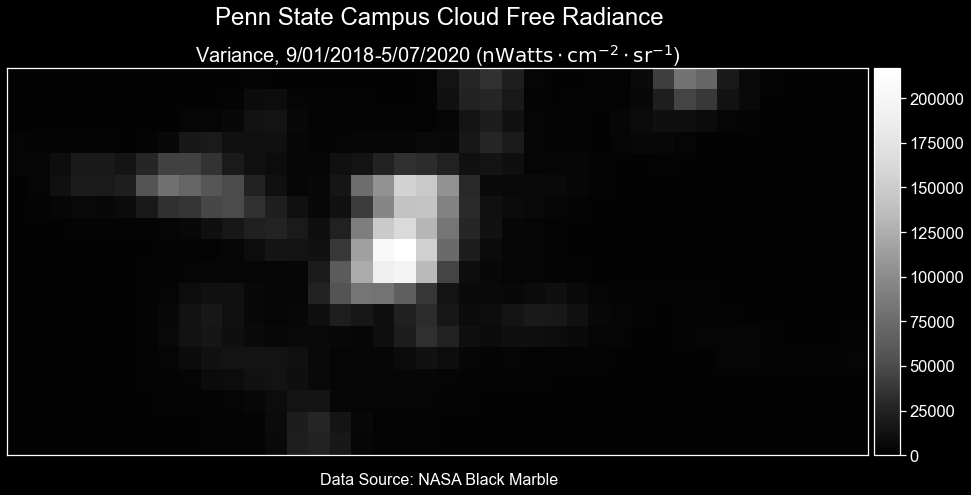

In [37]:
# Plot variance values
rd.plot_values(psu_radiance_variance_arr, title="Variance, 9/01/2018-5/07/2020")

plt.show()

### Standard Deviation

In [38]:
# Store continuous ranges means in dictionary
psu_radiance_deviation_dict = rd.store_continuous_range_statistic(
    radiance_daily=radiance_sept_2018_may_2020,
    date_range_list=psu_dates, statistic='deviation')

In [39]:
# Show keys (should be single key)
psu_radiance_deviation_dict.keys()

dict_keys(['20180901-20200507'])

In [40]:
# Get shape array
psu_radiance_deviation_dict.get('20180901-20200507').shape

(18, 40)

In [41]:
# Get radiance array
psu_radiance_deviation_arr = psu_radiance_deviation_dict.get('20180901-20200507')

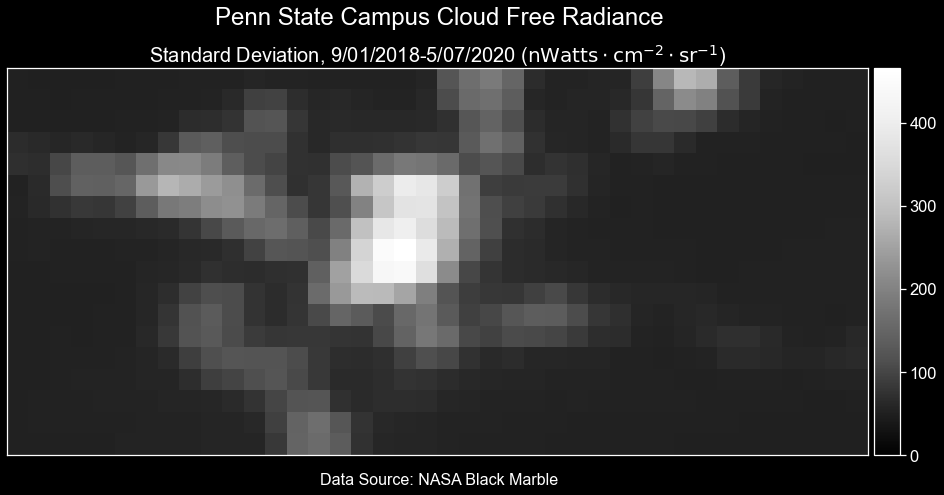

In [42]:
# Plot mean values
rd.plot_values(psu_radiance_deviation_arr, title="Standard Deviation, 9/01/2018-5/07/2020")

plt.show()

### Quartiles

#### Mean

In [43]:
# Get mean quartile arrays
mean_quartiles = rd.extract_quartiles(psu_radiance_mean_arr)

In [44]:
# Show keys
mean_quartiles.keys()

dict_keys(['quartile-1', 'quartile-2', 'quartile-3', 'quartile-4', 'quartile-1-2-3', 'quartile-2-3'])

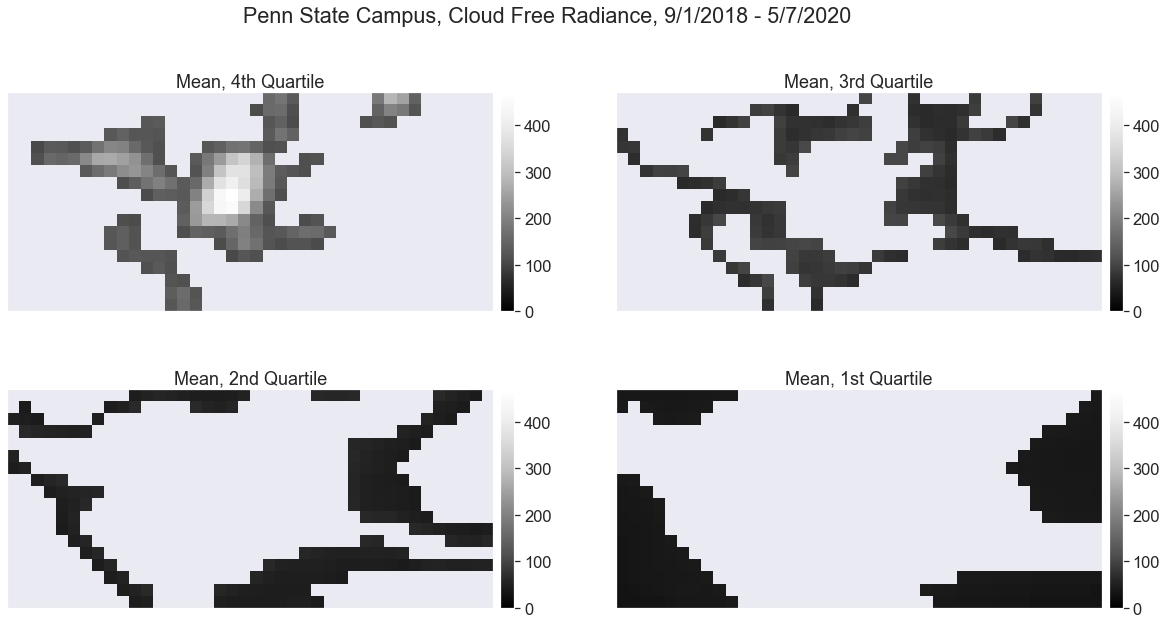

In [45]:
# Plot mean quartiles
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle("Penn State Campus, Cloud Free Radiance, 9/1/2018 - 5/7/2020")

ep.plot_bands(mean_quartiles.get('quartile-4'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[0][0],
              title='Mean, 4th Quartile')

ep.plot_bands(mean_quartiles.get('quartile-3'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[0][1],
              title='Mean, 3rd Quartile')

ep.plot_bands(mean_quartiles.get('quartile-2'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[1][0],
              title='Mean, 2nd Quartile')

ep.plot_bands(mean_quartiles.get('quartile-1'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[1][1],
              title='Mean, 1st Quartile')

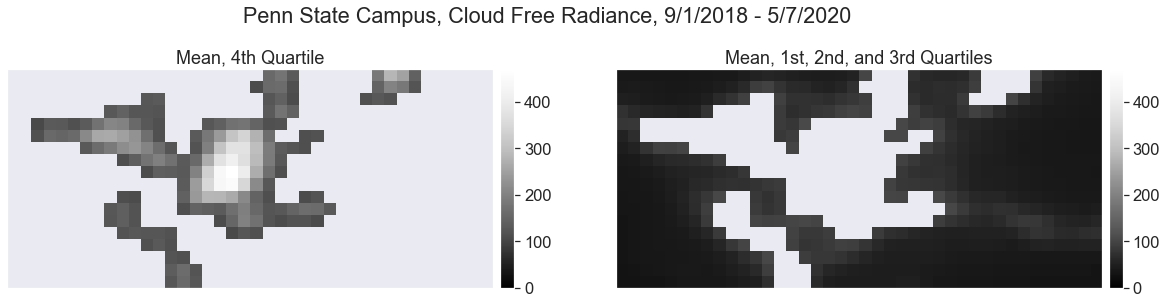

In [46]:
# Isolate 4th quartile
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

plt.suptitle("Penn State Campus, Cloud Free Radiance, 9/1/2018 - 5/7/2020")

ep.plot_bands(mean_quartiles.get('quartile-4'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[0],
              title='Mean, 4th Quartile')

ep.plot_bands(mean_quartiles.get('quartile-1-2-3'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[1],
              title='Mean, 1st, 2nd, and 3rd Quartiles')

#### Variance

In [47]:
# Get variance quartile arrays
variance_quartiles = rd.extract_quartiles(psu_radiance_variance_arr)

In [48]:
# Show keys
variance_quartiles.keys()

dict_keys(['quartile-1', 'quartile-2', 'quartile-3', 'quartile-4', 'quartile-1-2-3', 'quartile-2-3'])

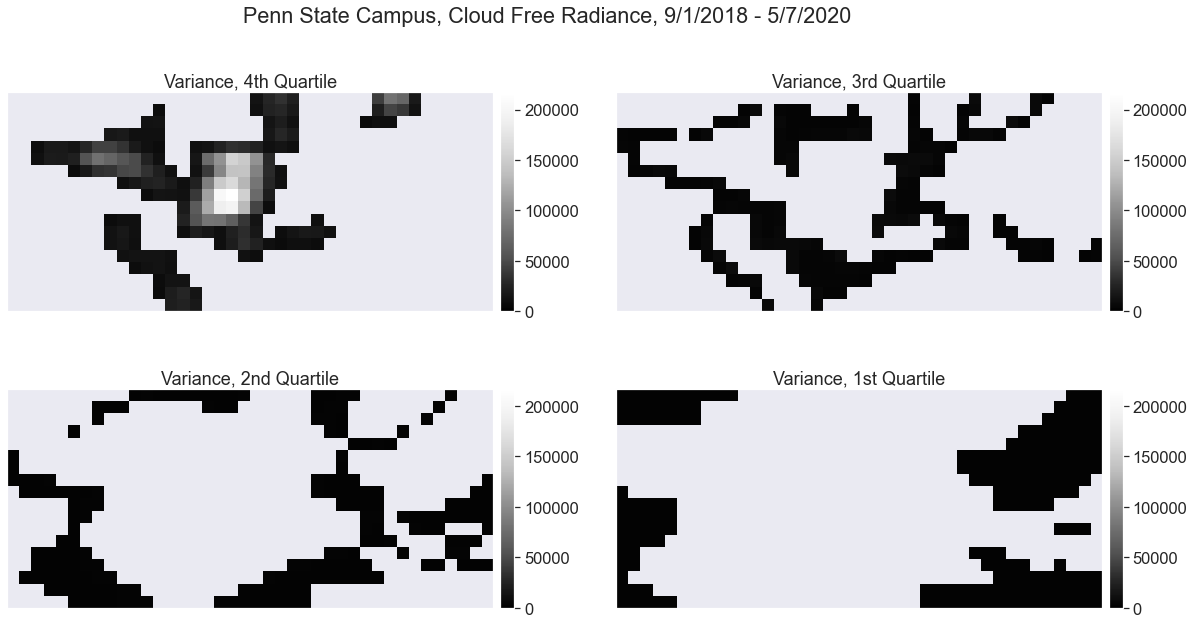

In [49]:
# Plot variance quartiles
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle("Penn State Campus, Cloud Free Radiance, 9/1/2018 - 5/7/2020")

ep.plot_bands(variance_quartiles.get('quartile-4'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[0][0],
              title='Variance, 4th Quartile')

ep.plot_bands(variance_quartiles.get('quartile-3'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[0][1],
              title='Variance, 3rd Quartile')

ep.plot_bands(variance_quartiles.get('quartile-2'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[1][0],
              title='Variance, 2nd Quartile')

ep.plot_bands(variance_quartiles.get('quartile-1'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[1][1],
              title='Variance, 1st Quartile')

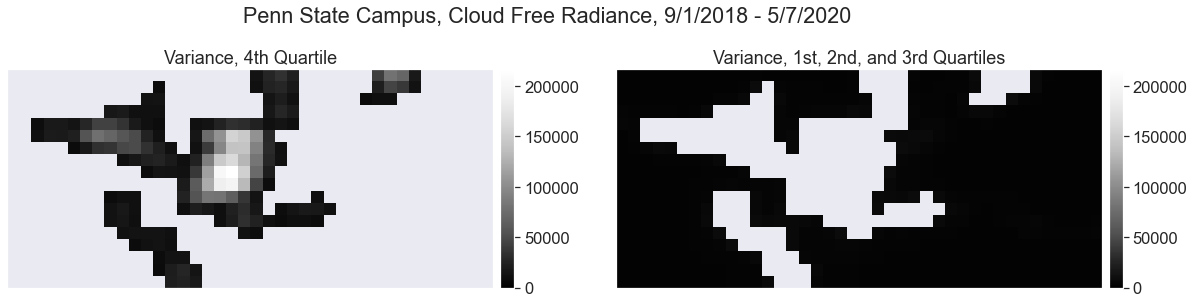

In [50]:
# Isolate 4th quartile
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

plt.suptitle("Penn State Campus, Cloud Free Radiance, 9/1/2018 - 5/7/2020")

ep.plot_bands(variance_quartiles.get('quartile-4'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[0],
              title='Variance, 4th Quartile')

ep.plot_bands(variance_quartiles.get('quartile-1-2-3'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[1],
               title='Variance, 1st, 2nd, and 3rd Quartiles')

#### Mean and Variance Together

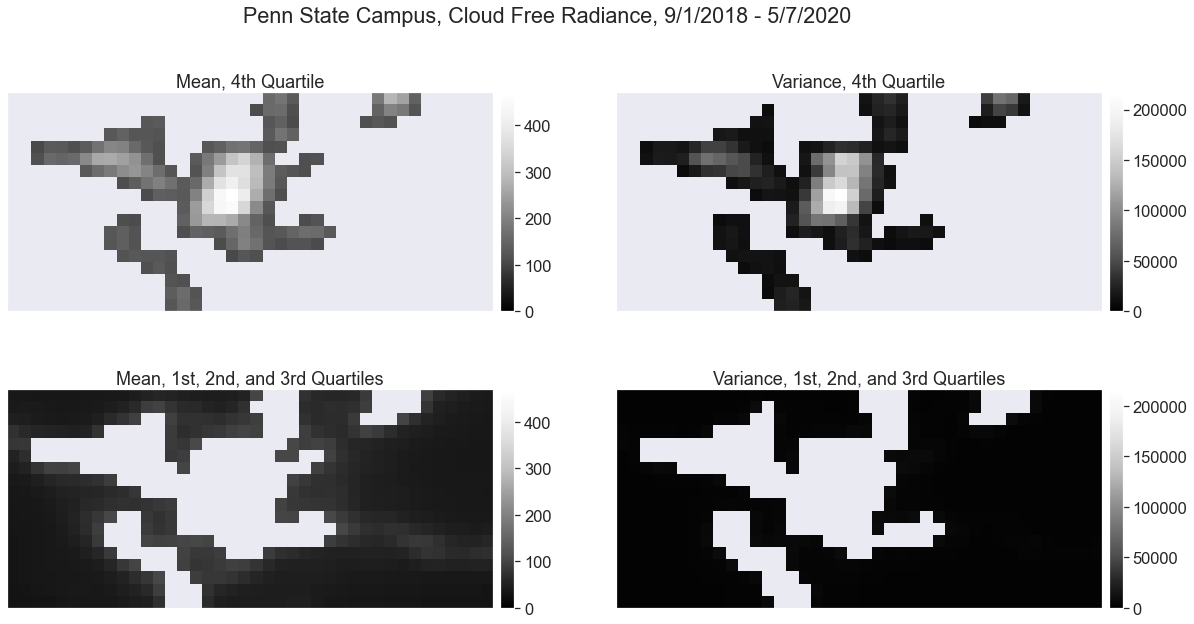

In [51]:
# Plot mean and variance together
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle("Penn State Campus, Cloud Free Radiance, 9/1/2018 - 5/7/2020")

ep.plot_bands(mean_quartiles.get('quartile-4'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[0][0],
              title='Mean, 4th Quartile')

ep.plot_bands(mean_quartiles.get('quartile-1-2-3'), scale=False, vmin=0,
              vmax=psu_radiance_mean_arr.max(), ax=ax[1][0],
              title='Mean, 1st, 2nd, and 3rd Quartiles')

ep.plot_bands(variance_quartiles.get('quartile-4'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[0][1],
              title='Variance, 4th Quartile')

ep.plot_bands(variance_quartiles.get('quartile-1-2-3'), scale=False, vmin=0,
              vmax=psu_radiance_variance_arr.max(), ax=ax[1][1],
               title='Variance, 1st, 2nd, and 3rd Quartiles')

## Plot Study Area Means Time Series

### Full Data Set

In [52]:
# Get list of time series means for PSU campus
psu_time_series = rd.store_time_series_means(
    radiance_daily=radiance_sept_2018_may_2020,
    start_date='2018-09-01',
    end_date='2020-05-07')

In [53]:
# Check type
type(psu_time_series)

pandas.core.frame.DataFrame

In [54]:
# Check length (should be 615)
len(psu_time_series)

615

In [55]:
# Show dataframe
psu_time_series.head()

,mean_radiance,percent_masked
2018-09-01,105.333333,0.9833
2018-09-02,74.211538,0.7111
2018-09-03,78.283916,0.0069
2018-09-04,83.359722,0.0000
2018-09-05,79.333333,0.0000


In [56]:
# Get first record
psu_time_series.loc['2018-09-01']

mean_radiance     105.333333
percent_masked      0.983300
Name: 2018-09-01 00:00:00, dtype: float64

In [57]:
# Calculate mean of study area means (for plotting)
psu_time_series_mean_val = psu_time_series[['mean_radiance']].mean(skipna=True)[0]

In [58]:
# Show time series mean
psu_time_series_mean_val

100.93011225726116

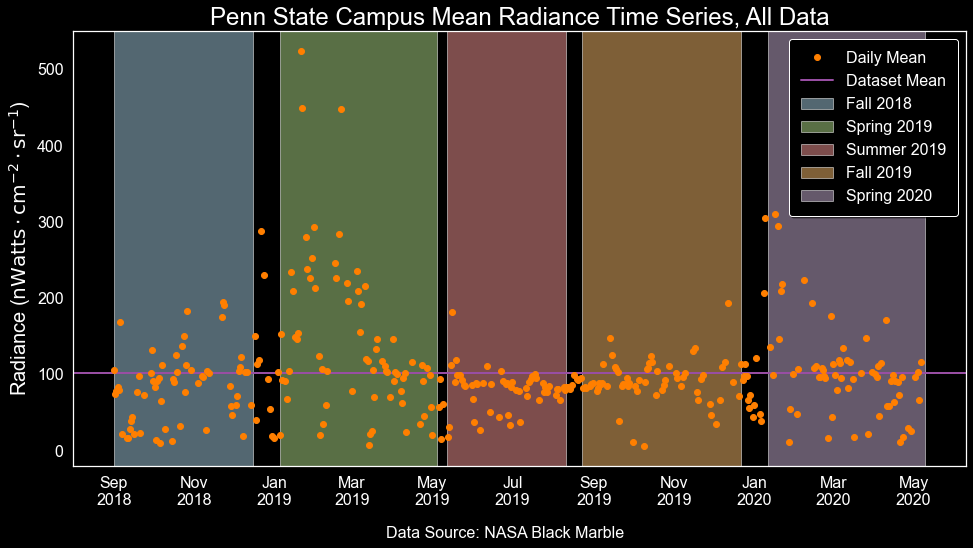

In [59]:
# Plot time series data, dataset mean, and time periods of interest
with plt.style.context('dark_background'):

    # Create figure and axes object
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot time series mean radiance
    ax.plot(psu_time_series.index.values,
            psu_time_series.mean_radiance,
            markersize=6,
            marker='o',
            linestyle='',
            label='Daily Mean',
            color='#ff7f00')

    # Define the date format
    date_form = DateFormatter("%b\n%Y")
    ax.xaxis.set_major_formatter(date_form)

    # Turn plot grid off
    ax.grid(False)

    # Ploe mean value
    ax.axhline(psu_time_series_mean_val, zorder=1, linewidth=2,
               color='#984ea3', label="Dataset Mean")

    # Plot semester date ranges, from Fall 2018 to Spring 2020
    plt.axvspan(pd.to_datetime('2018-09-01'), pd.to_datetime('2018-12-16'),
                facecolor='#a6cee3', alpha=0.5, label='Fall 2018')

    plt.axvspan(pd.to_datetime('2019-01-05'), pd.to_datetime('2019-05-05'),
                facecolor='#b2df8a', alpha=0.5, label='Spring 2019')

    plt.axvspan(pd.to_datetime('2019-05-12'), pd.to_datetime('2019-08-11'),
                facecolor='#fb9a99', alpha=0.5, label='Summer 2019')

    plt.axvspan(pd.to_datetime('2019-08-23'), pd.to_datetime('2019-12-22'),
                facecolor='#fdbf6f', alpha=0.5, label='Fall 2019')

    plt.axvspan(pd.to_datetime('2020-01-11'), pd.to_datetime('2020-05-10'),
                facecolor='#cab2d6', alpha=0.5, label='Spring 2020')

    # Add caption
    fig.text(0.5, 0, f"Data Source: NASA Black Marble",  # {data_source}",
             ha='center', fontsize=16)

    # Configure axes
    ax.set_xlabel("")
    ax.set_ylabel("Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)")
    ax.set_title("Penn State Campus Mean Radiance Time Series, All Data")
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    # Add legend
    ax.legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)

### Data Subset Based on Percent Masked Value

In [60]:
# Define percent masked threshold
mask_percent = 0.5

# Get data with <= 50% masked data
psu_time_series_mask_50 = psu_time_series[psu_time_series.percent_masked <= mask_percent]

In [61]:
# See how many values in df (# radiance and masked should match)
psu_time_series_mask_50.count()

mean_radiance     202
percent_masked    202
dtype: int64

In [62]:
# Calculate mean of study area means (for plotting)
psu_time_series_mask_50_mean_val = psu_time_series_mask_50[['mean_radiance']].mean(skipna=True)[0]

In [63]:
# Show time series mean
psu_time_series_mask_50_mean_val

112.88808840174487

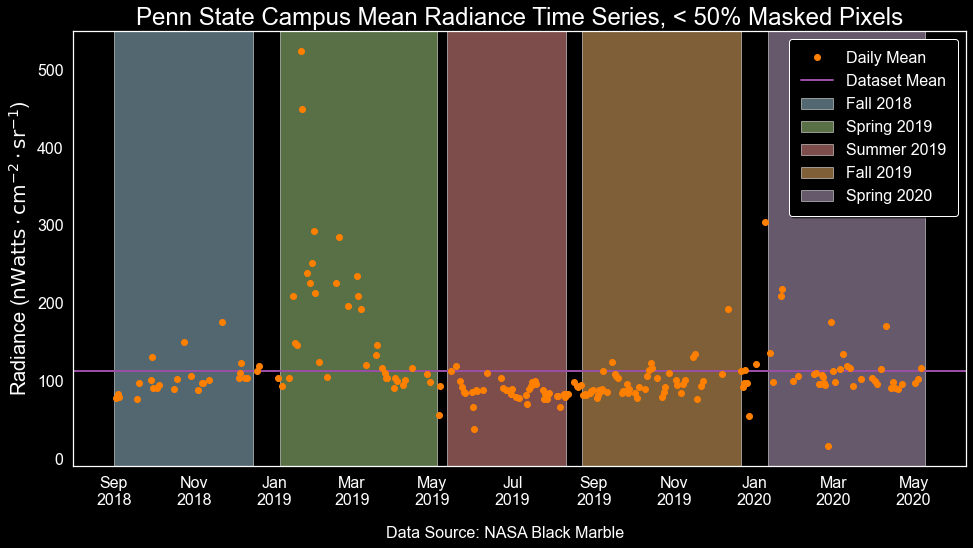

In [64]:
# Plot time series data for <= 50% masked
with plt.style.context('dark_background'):

    # Create figure and axes object
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot time series mean radiance
    ax.plot(psu_time_series_mask_50.index.values, psu_time_series_mask_50.mean_radiance, markersize=6,
            marker='o', linestyle='', label='Daily Mean', color='#ff7f00')
        
    # Define the date format
    date_form = DateFormatter("%b\n%Y")
    ax.xaxis.set_major_formatter(date_form)

    # Turn plot grid off
    ax.grid(False)

    # Ploe mean value
    ax.axhline(psu_time_series_mask_50_mean_val, zorder=1, linewidth=2,
               color='#984ea3', label="Dataset Mean")

    # Plot semester date ranges, from Fall 2018 to Spring 2020
    plt.axvspan(pd.to_datetime('2018-09-01'), pd.to_datetime('2018-12-16'),
                facecolor='#a6cee3', alpha=0.5, label='Fall 2018')

    plt.axvspan(pd.to_datetime('2019-01-05'), pd.to_datetime('2019-05-05'),
                facecolor='#b2df8a', alpha=0.5, label='Spring 2019')

    plt.axvspan(pd.to_datetime('2019-05-12'), pd.to_datetime('2019-08-11'),
                facecolor='#fb9a99', alpha=0.5, label='Summer 2019')

    plt.axvspan(pd.to_datetime('2019-08-23'), pd.to_datetime('2019-12-22'),
                facecolor='#fdbf6f', alpha=0.5, label='Fall 2019')

    plt.axvspan(pd.to_datetime('2020-01-11'), pd.to_datetime('2020-05-10'),
                facecolor='#cab2d6', alpha=0.5, label='Spring 2020')

    # Add caption
    fig.text(0.5, 0, f"Data Source: NASA Black Marble",
             ha='center', fontsize=16)

    # Configure axes
    ax.set_xlabel("")
    ax.set_ylabel("Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)")
    ax.set_title("Penn State Campus Mean Radiance Time Series, < 50% Masked Pixels")
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    # Add legend
    ax.legend(borderpad=0.75, edgecolor='w', fontsize=16, shadow=True)